In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from plot_post import plot_post

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Modelos lineales generalizados (MLG)

En los cápitulos pasados vimos como crear y analizar modelos Bayesianos, aplicados a distribuciones, binomiales, Poisson, Gaussianas y t. En el presente capítulo veremos un modelo ampliamente usado en estadistica el modelo linear generalizado. Este modelo es la base de métodos como la regresión lineal, regresión multiple, regresión logística y métodos muy conocidos entre los frecuentistas como el t-test, analisis de la varianza (ANOVA), etc.

En los modelos lineales generalizados se suele hablar de variables independientes y dependientes, o predictoras y predichas. Por ejemplo si quisieramos predecir el peso de una persona a partir de la edad, el peso sería la variable independiente y la edad la dependiente, pero esos roles cambiarían si quisieramos predecir la edad a partir del peso. La razón del nombre independiente (o predictora) es que el valor de esa variable no es predicho por el modelo si no que es establecido desde afuera del modelo es una entrada (_input_) del modelo y no un resultado. Hay que tener en claro que cuando hablamos de dependencia es por que en nuestro modelo hacemos que una variable dependa de la otra, pero esto no quiere decir, necesariamente, que exista una relación causal entre las variables. .

Es decir los MLG lo único que pueden llegar a establecer es la existencia de una relación lineal entre las variables, y por lo tanto la posibilidad de predecir una variable midiendo la otra. Pero hay que dejar en claro que estabamos hablando de correlación entre variables no de relación causa-efecto. Es decir dependiendo del diseño experimental un MLG podrá ser usado para establecer una relacion causa-efecto entre variables o solo el grado de correlación entre variables.

Los MLG tienen una forma común, pero su implementación e interpretación dependen de la naturaleza de las variables de interes.

## Tipos de variables: Métricas, ordinales y categóricas.


* Métricas o cuantitativas: Son variables con las cuales es posible establecer un orden y computar distancias. Cuando en la escala existe un cero es posible además calcular proporciones, por ejemplo 1 hora es la mitad de 2 horas (por que 0 horas implica la ausencia de tiempo transcurrido). En cambio $40 ^\circ \text{C}$ no es el doble de $20 ^\circ \text{C}$, por que el cero de la escala Celcius es un punto totalmente arbitrario (esto no sucede con la escala Kelvin).
    * Continuas: Se describen usando el conjunto de los números reales, algunos ejemplos son la temperatura, altura, peso, etc.
    * Discretas: Se describen usando el conjunto de los enteros, Número de hijos, cantidad de caramelos, número de aviones de una aerolíneas, etc.

* Cualitativas: Son el tipo de variables que indican cualidades, o atributos.
    * Categóricas: Son variables que indican pertenencia a categorías mutuamente excluyentes, como cara o ceca en una moneda. Además no es posible establecer orden alguno, cara no es más o menos que ceca, o o ceca no viene antes que cara. Aún cuando se usen números como 1 y 0 para representarlo no se puede decir que entre cara y ceca hay una unidad de distancia. Las variables categóricas no tienen por que ser dos pueden ser millones, como los colores.
    * Ordinales: La variable puede tomar distintos valores ordenados siguiendo una escala establecida, aunque el intervalo no tiene por que ser uniforme, por ej el ranking en una carrera, la distancia entre el primero y el segundo no tiene por que ser las misma que entre el segundo y el tercero.

    
## La base de los MLG

Lo más probable es que ustedes ya conozcan la base de los MLG, la regresión lineal simple:
    
$$y = \alpha + \beta x $$

En este modelo $x$ se conoce como variable independiente (o variable predictora) e $y$ se conoce como varible dependiente (o variable predictora). $beta$ es la pendiente e indica el cambio de $y$ por unidad de cambio de $x$, $alpha$ indica el punto en que la recta corta la ordenana al origen (el eje de las $y$)

Todos los MLG se pueden considerar variantes de la regresion lineal simple como empezaremos a ver en este capítulo y seguiremos en posteriores. Esta ecuación puede ser resuelta de forma muy eficiente si se la expresa matricialmente y se utiliza lo que se conoce como ecuación normal. Cada vez que ustedes hayan calculado el ajuste a una recta (por mínimos cuadrados) con algún paquete o función, lo más probable es que ese paquete/función internamente haya resuelto la ecuación normal. Este método devuelve el par de valores para la pendiente y la ordenada al origen que producen el menor error cuadratico medio entre los pares los pares $(x, y)$. El método asume que la diferencia entre los valores de los pares $(x, y)$ sigue una distribución Gaussiana.

Nosotros vamos a resolver el ajuste de una recta, pero de forma probabilistica (Bayesiana). Esto nos permitirá no solo obtener los mejores valores si no una estimación de la incerteza con la que conocemos esos valores. Además nos permitirá facilmente adaptar la regresión lineal a modelos con mas parámetros o que no asumen normalidad o que se adaptan mejor a nuestro problema. Reformulado probabilisticamentela regresión lineal simple (y la base para todos los GLMs) tiene la siguiente forma:


$$ y \sim \mathcal{N}(\alpha + \beta x, \sigma) $$


Dado que desconocemos los valores de $\alpha$, $\beta$ y $\sigma$ debemos fijar _a prioris_, una posibilidad serían los siguientes.

$$\alpha \sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha})$$
$$\beta \sim \mathcal{N}(\mu_{\beta}, \sigma_{\beta}) $$
$$\sigma \sim \mathcal{U}(l_{\sigma}, h_{\sigma}) $$

Lo que estamos diciendo entonces, es que en nuestro modelo $\alpha + \beta x$ corresponde a los valores de la media de una distribución gaussiana con desviación estandard desconocida $\sigma$.

In [2]:
np.random.seed(1)
N = 300
alfa_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
# y = a + b*x + e
y_real = alfa_real + beta_real * x 
y = y_real + eps_real

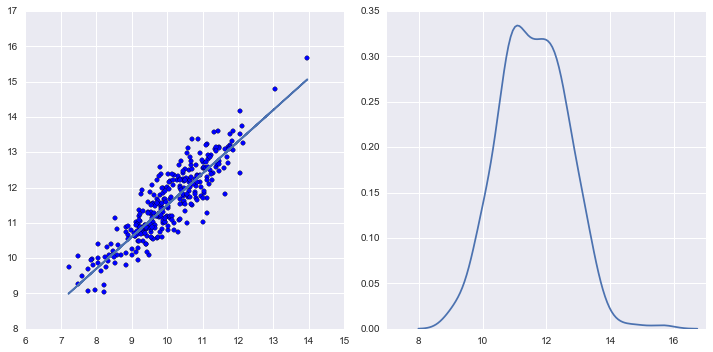

In [3]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(x, y);
plt.plot(x, y_real);
plt.subplot(1,2,2)
sns.kdeplot(y);
plt.tight_layout()

In [4]:
with pm.Model() as modelo:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=100)
    epsilon = pm.Uniform('epsilon', lower=0, upper=20)
        
    likelihood = pm.Normal('y', mu=alpha + beta * x, sd=epsilon, observed=y)
    
    start = pm.find_MAP() 
    step = pm.Metropolis() 
    trace = pm.sample(50000, step, start=start, progressbar=True)

 [-----------------100%-----------------] 50000 of 50000 complete in 17.2 sec

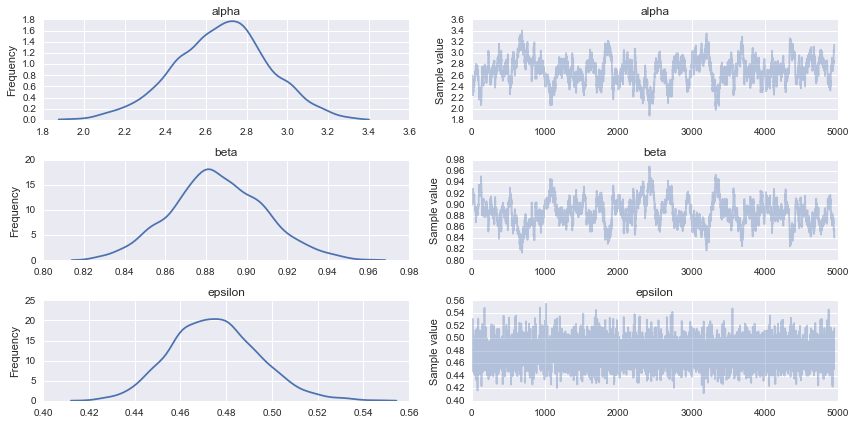

In [5]:
burnin = 500
thinin = 10
cadena = trace[burnin::thinin]
pm.traceplot(cadena, vars=[alpha, beta, epsilon]);

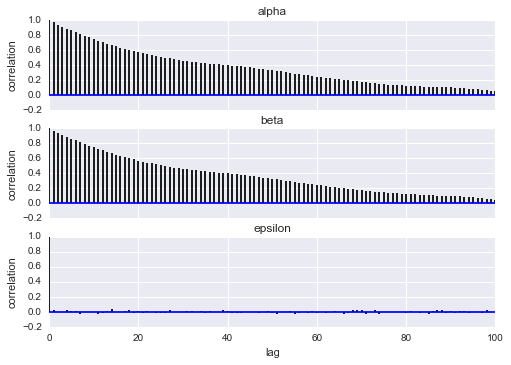

In [6]:
pm.autocorrplot(cadena, vars=[alpha, beta, epsilon]);

In [7]:
pm.summary(cadena)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  2.679            0.234            0.020            [2.220, 3.149]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  2.196          2.524          2.687          2.830          3.138


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.886            0.023            0.002            [0.842, 0.934]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.841          0.871          0.885          0.902          0.933


epsilon_interval:

  Mean             SD               MC Error         95% HPD interval
  ---------------

### Modificando los datos antes de muestrear

En el ejemplo anterior habrán visto que la autocorrelacion para $\alpha$ y $\beta$ es alta. La razón es que la pendiente y la ordenada al origen estan correlacionadas entre si ¿Por qué? 

Todas las posibles rectas que ajusten los datos deben pasar por el punto medio de $x$ y el punto medio de $y$ alrededor de ese punto al aumentar la pendiente la ordena al origen deberá disminuir y viceversa. Esta correlación puede hacer que el espacio de los valores más plausibles (que es lo que debemos muestrear) sea una "diagonal". Algo como lo siguiente:

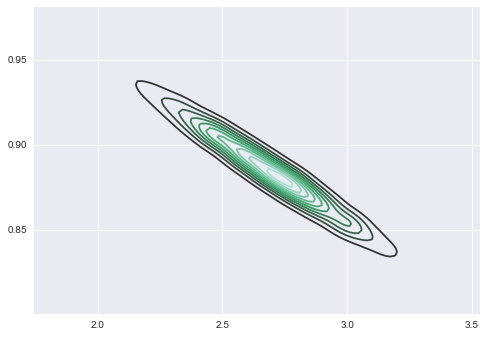

In [8]:
sns.kdeplot(cadena['alpha'], cadena['beta']);

Para algoritmos como Metropolis-Hastings esto puede ser problemático. Ya que la mayoría de las propuestas serán rechazadas y los valores aceptados estarán fuertemente correlacionados entre si. Imaginen en la figura anterior tener que moverse de una punta al centro de la elipse. Para moverse van alternando entre un paso en $x$ y uno en $y$, queda claro que la única forma de moverse por espacios de alta probabilidad es en zig-zag, un pequeño paso en $x$ seguido de un pequeño paso en $y$, es decir la convergencia es lenta y cada nuevo paso no puede estar muy lejos del anterior (está correlacionado con el anterior).  Este problema aumenta a medida que aumentan las varibles/dimensiones del problema. A medida que aumentan las dimensiones disminuye el cociente entre el _volumen_ que corresponde a posiciones de baja probabilidad y el volumen total.

Una solución es centrar los datos en $x$, es decir a cada punto restarle la media de todos los puntos $\bar{x}$. Como resultado el centro de $x$ será 0, es decir el punto alrededor del cual se mueve la recta al cambiar la pendiente será alrededor de la ordenada al origen, por lo que el espacio a muestrear es ahora mas "circular" o menos correlacionado. Hay que tener cuidado que si centramos los datos, los valores para la ordenada al origen obtenida con los datos centrados tendrá que ser corregida al finalizar el análisis. 

$$x^* = x - \bar{x}$$
$$\alpha = \alpha^* + \beta^* \bar{x}$$

Queda como ejercicio, hacer la prueba de centrar los datos antes de resolver el modelo y revisar como cambia la autocorrelación los resultados obtenidos y la correlación entre $\alpha$ y $\beta$.

En muchos casos no solo resulta conveniente centrar los datos si no que puede ser convenientes estandarizarlos es decir

$$x^* = \frac{x - \bar{x}}{x_{sd}}$$
$$y^* = \frac{y - \bar{y}}{y_{sd}}$$

Una ventaja de estandarizar los datos, es que siempre es posible aplicar los mismos _a prioris_ minimamente informativos, sin preocuparse por la escala de los datos.

Estandarizar los datos previo a un análisis es una transformación comunmente aplicada en estadística y machine learning. En muchos problemas el rango para distintas variables puede ser muy diferente, incluso ordenes de magnitud diferente esto hace que mucho algoritmos (no solo Metropolis-Hastings) tengan problemas. Por ej cualquier algoritmo que confíe en computar distancias euclídeas se verá afectado, ya que sin estandarizar el valor de la distancia dependerá fuertemente de la variable con el rango más extendido, pudiendo opacar la contribución de otras variables, otro caso corresponde a algoritmos que hace uso del minimizador _gradiente descendiente_, ya que este algoritmo también deberá zigzagear si las variables no han sido estandarizadas. En definitiva si nuestro método de muestreo tiene problemas es probable que una de las causas sea la falta de estandarización de los datos.

Por supuesto si el problema reside en el método de muestreo una posible solución es usar otros métodos de muestreo. NUTS (y en general el Hamiltonian Monte Carlo, del cual deriva NUTS) fue diseñado precisamente para resolver este tipo de problemas. Para usar NUTS basta con reemplazar _pm.Metropolis()_ por _pm.NUTS()_. NUTS requiere de un parámetro llamado _scaling_, este parámetro le indica que algo así como que tan grande pueden ser los pasos en cada dimensión. Si bien NUTS es capaz de estimar este parámetro es recomenable darle un valor inicial razonable, una forma simple de hacer esto es diciendole que _scaling_ es igual al resultado de _find_MAP()_. Un mal valor de _scalling_ puede hacer que NUTS funcione muy lentamente o que incluso se detenga. Al ser NUTS más eficiente que Metropolis suele ser necesario muestrear un menor número de pasos, un periodo _burnin_ más corto y un menor _thining_.

In [9]:
with pm.Model() as modelo_n:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=100)
    epsilon = pm.Uniform('epsilon', lower=0, upper=20)
        
    likelihood = pm.Normal('y', mu=alpha + beta * x, sd=epsilon, observed=y)
    
    start = pm.find_MAP() 
    #step1 = pm.Metropolis([epsilon]) 
    #step2 = pm.NUTS([alpha, beta], scaling=start) 
    step = pm.NUTS(scaling=start) 
    trace_n = pm.sample(20000, step=step, start=start, progressbar=True)
    #trace_n = pm.sample(5000, step=[step1, step2], start=start, progressbar=True)

 [-----------------100%-----------------] 20000 of 20000 complete in 33.3 sec

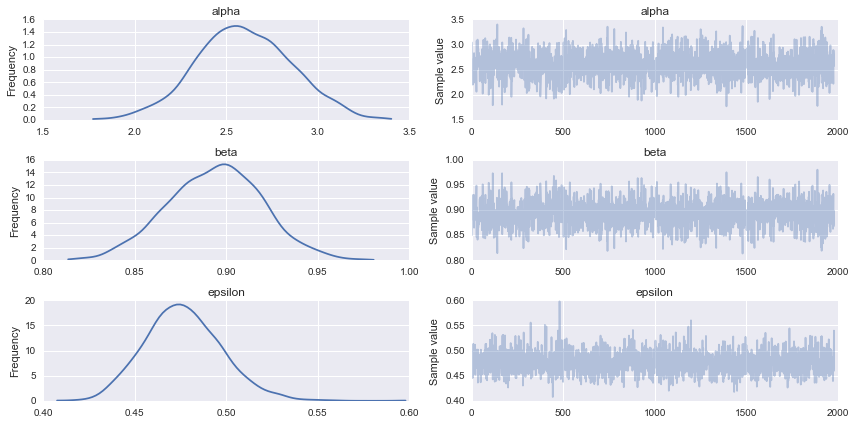

In [10]:
cadena_n = trace_n[200::10]
pm.traceplot(cadena_n, vars=[alpha, beta, epsilon]);

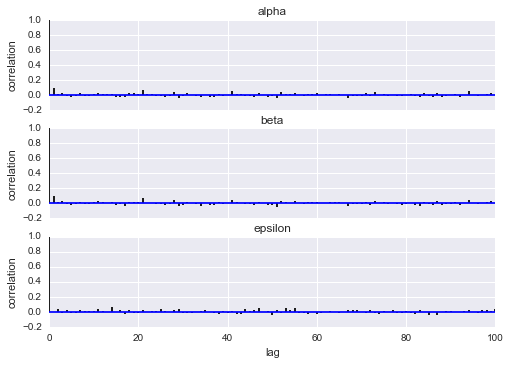

In [11]:
pm.autocorrplot(cadena_n, vars=[alpha, beta, epsilon]);

In [12]:
pm.summary(cadena_n)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  2.598            0.260            0.006            [2.125, 3.142]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  2.077          2.420          2.589          2.775          3.111


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.894            0.026            0.001            [0.846, 0.948]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.843          0.876          0.895          0.912          0.945


epsilon_interval:

  Mean             SD               MC Error         95% HPD interval
  ---------------

### Interpretando el _a posteriori_

En los ejemplos anteriores hemos usado _a prioris_ muy difusos, pero en un problema real es posible que contemos con información util que nos permita usar _a prioris_ algo más informativos.
 
Para explorar el _a posteriori_ podemos usar las funciones _traceplot_ y _summary_ ofrecidas por PyMC3 o podemos usar nuestras propias funciones. Por ejemplo puede ser útil simplemente hacer una gráfica y reportar los valores medios de $\alpha$ y $\beta$.

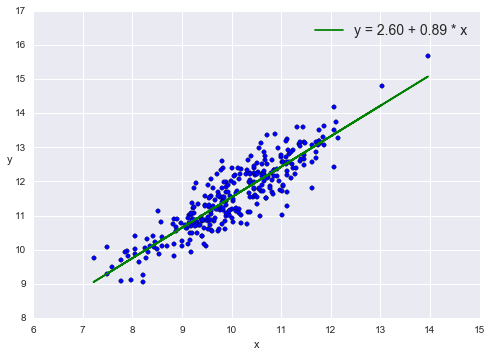

In [13]:
plt.scatter(x, y);
#plt.plot(x, y_real, color='r')
alfa_m = cadena_n['alpha'].mean()
beta_m = cadena_n['beta'].mean()
plt.plot(x, alfa_m + beta_m*x, c='g', label='y = {:.2f} + {:.2f} * x'.format(alfa_m, beta_m))
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=0, fontsize=14);

O hacer una gráfica con rectas semitransparentes tomadas del _a posteriori_, para dar una idea visual de la incertidumbre de nuestra estimación.

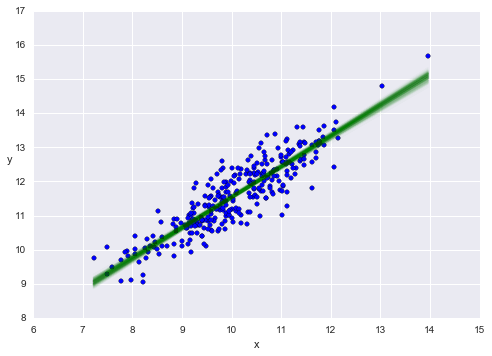

In [14]:
plt.scatter(x, y);
#plt.plot(x, y_real, linewidth=3, color='r')
plt.xlabel('x')
plt.ylabel('y', rotation=0)
for i in range(0, len(cadena_n['alpha']), 10):
    plt.plot(x, cadena_n['alpha'][i] + cadena_n['beta'][i]*x, c='g', alpha=0.02);

Cuando realizamos una regresión lineal es posible que solo nos interese saber cual es el cambio de la variable dependiente cuando cambiamos la independiente. En ese caso deberemos mirar el valor de $\beta$ el _a posteriori_ contiene toda la información posible sobre $\beta$ dado el modelo y los datos.

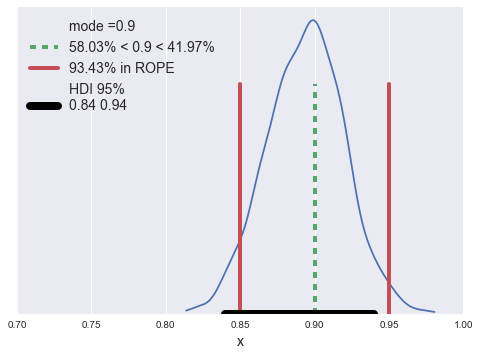

In [15]:
plot_post(cadena_n['beta'], xlab='x', comp_val=.9, ROPE=[0.85,.95])
plt.xlim(0.7, 1);

Podría ser que nos interese determinar si los valores de la pendiente son o no compatibles con algún valor, por ejemplo 0 si lo que intentamos determinar es si existe algun efecto de una variable sobre la otra. O si la pendiente es positiva o negativa, ya que hay estudios previos que indican ambas posibilidades, etc. Como vimos anteriormente esto se puede hacer reportando directamente el _a posteriori_ o reportando el HDI junto con la media o el modo, o haciendo uso de la ROPE.

### Posterior prediction check

### Regresión lineal robusta

La idea de asumir normalidad en la distribución de los errores es un subproducto de una era en donde las computadoras no existían y por lo tanto los cálculos había que hacerlos a mano, por lo tanto las personas buscaban (razonablemente) formas simples de resolver anaĺíticamente los problemas. Pero hoy en día eso no es una restricción como solía serlo. Por esto no quiero decir que resolver problemas analíticamente no sea provechoso, solo que en muchos casos es posible otras aproximaciones. En general los datos que usamos rara vez son normales, aunque muchas veces son lo "suficientemente normales" como para que los métodos que asuemen normalidad funcionen bien. De todas formas ¿No sería mejor contar con un método que en vez de asumir normalidad, se adapte automáticamente al grado de normalidad de los datos y además permita estimar ese grado de normalidad? Evidentemente la respuesta a esta pregunta es positiva (caso contrario hacer la pregunta sería una forma extraña de terminar el capítulo).

Una solución a nuestro problema es usar una distribución t de student en vez de una gaussiana, lo interesante de esta distribución es que además de estar definida por una media y una desviación estandard está definida por un parámetro usualmente llamado $\nu$ (o grados de libertad), este parámetro controla cuan gordas son las colas de la distribución cuando $nu=1$ las colas son muy gordas, el 95% de los puntos está entre -12,7 y 12-7, en cambio en una Gaussiana esto ocurre entre -1,96 y 1,96. En el límite de $\nu$ tendiendo a infinito estamos en presencia de una Gaussiana. Por lo que podemos decir que $\nu$ controla la _normalidad_ de la dsitribución.

https://en.wikipedia.org/wiki/Student's_t-distribution

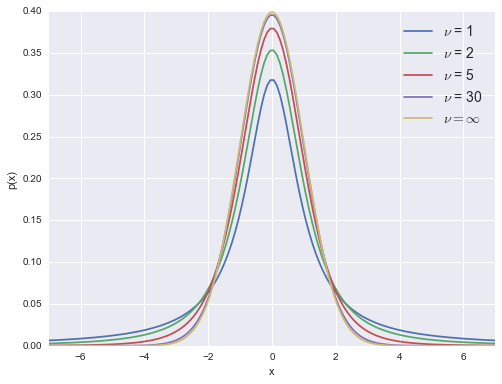

In [16]:
plt.figure(figsize=(8, 6))

x_values = np.linspace(-10, 10, 200)
for df in [1, 2, 5, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=r'$\nu$ = {}'.format(df))

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, label=r'$\nu = \infty$')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend(loc=0, fontsize=14)
plt.xlim(-7, 7);

In [17]:
# https://en.wikipedia.org/wiki/Anscombe's_quartet tercer data set
x_3 = np.array([10.0, 8.0, 13.0, 9.0, 11.0, 14.0, 6.0, 4.0, 12.0, 7.0, 5.0])
y_3 = np.array([7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73])

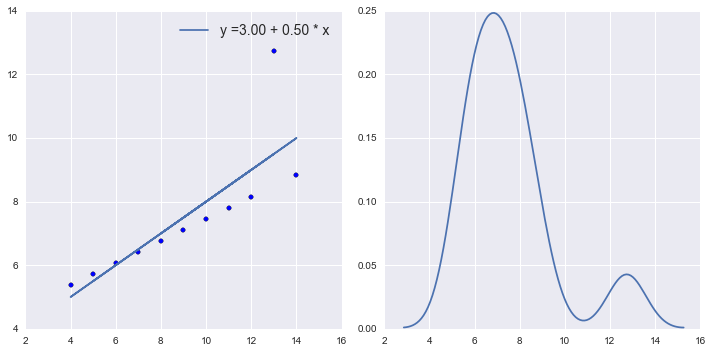

In [18]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
beta_c, alfa_c = stats.linregress(x_3, y_3)[:2]
plt.plot(x_3, (alfa_c + beta_c* x_3), label='y ={:.2f} + {:.2f} * x'.format(alfa_c, beta_c));
plt.scatter(x_3, y_3);
plt.legend(loc=0, fontsize=14)
plt.subplot(1,2,2)
sns.kdeplot(y_3);
plt.tight_layout()

In [19]:
with pm.Model() as modelo_t:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=100)
    epsilon = pm.Uniform('epsilon', lower=0, upper=20)
    nu0 = pm.Uniform('nu0', 0, 0.5)
    nu = pm.Deterministic('nu', 1/nu0)
    #nu0 = pm.Exponential('nu0', 1/29)
    #nu = pm.Deterministic('nu', nu0 + 1)
    
    
    likelihood = pm.T('y', mu=alpha + beta * x_3, sd=epsilon, nu=nu, observed=y_3)
    
    start = pm.find_MAP()
    #step1 = pm.Metropolis([epsilon, nu]) 
    #step2 = pm.NUTS([alpha, beta], scaling=start) 
    step = pm.NUTS(scaling=start) 
    trace_t = pm.sample(5000, step=step, start=start, progressbar=True)
    #trace_t = pm.sample(5000, step=[step1, step2], start=start, progressbar=True)

 [-----------------100%-----------------] 5000 of 5000 complete in 8.5 sec

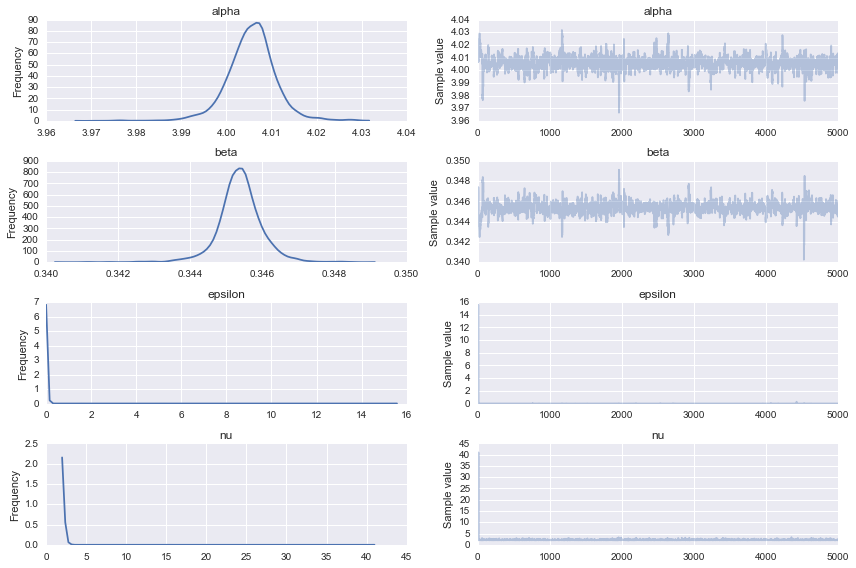

In [20]:
cadena_t = trace_t[::]
pm.traceplot(cadena_t, vars=[alpha, beta, epsilon, nu]);

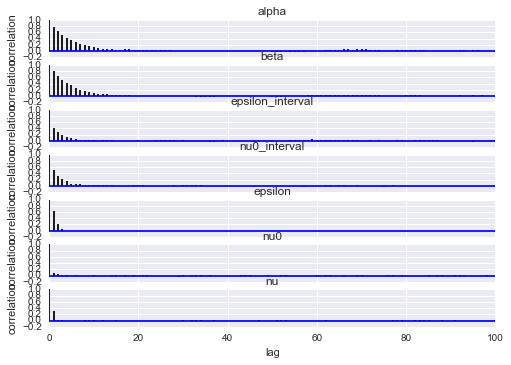

In [21]:
pm.autocorrplot(cadena_t);

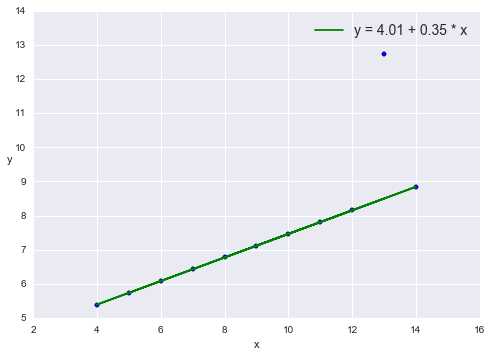

In [22]:
plt.scatter(x_3, y_3);
alfa_m = cadena_t['alpha'].mean()
beta_m = cadena_t['beta'].mean()
plt.plot(x_3, alfa_m + beta_m*x_3, c='g', label='y = {:.2f} + {:.2f} * x'.format(alfa_m, beta_m))
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=0, fontsize=14);

In [23]:
import sys, IPython, scipy, matplotlib, platform
print("Esta notebook fue creada en una computadora %s corriendo %s y usando:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

Esta notebook fue creada en una computadora x86_64 corriendo Ubuntu 15.10 y usando:
Python 3.5.0
IPython 4.0.0
PyMC3 3.0
NumPy 1.10.1
SciPy 0.16.1
Matplotlib 1.5.0
Seaborn 0.6.0

